In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from region_new import Region, emission_simple
from lclu.constant import lcz_cmap, lcz_hight

In [3]:
import os
import json
import numpy as np
import pickle
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

In [4]:
# bounding boxes
bounding_box = json.load(open('bounding_box.json'))

In [5]:
# census data
tk_cen_path = os.path.join("data","census","tk_summary.xlsx")
za_cen_path = os.path.join("data","census","za_summary.xlsx")
eg_cen_path = os.path.join("data","census","eg_summary.xlsx")

tk_cen = pd.read_excel(tk_cen_path, "mean")
za_cen = pd.read_excel(za_cen_path, "mean")
eg_cen = pd.read_excel(eg_cen_path, "mean") 
tk_cen = tk_cen.groupby(["region","city","year"]).mean().reset_index()
# we only take the most recent year
tk_cen = tk_cen.groupby(["region","city"], sort=False)['year'].max().reset_index().merge(tk_cen, on=["region","city","year"])
eg_cen = eg_cen.groupby(["region","city"], sort=False)['year'].max().reset_index().merge(eg_cen, on=["region","city","year"])

# tk_cen.loc[tk_cen["city"]=='Altınordu', "city"] = "Merkez"
# tk_cen.loc[tk_cen["city"]=='Ortahisar', "city"] = "Merkez"
tk_cen.loc[tk_cen["city"]=='Yunusemre', "city"] = "Merkez"
za_cen = za_cen.groupby(["region","city","year"]).mean().reset_index()
eg_cen = eg_cen.groupby(["region","city","year"]).mean().reset_index()

In [6]:
# house data
ordu_house = os.path.join("data","clipped_house","Ordu_house.pkl")
johannesburg_house = os.path.join("data","clipped_house","Johannesburg_house.pkl")
cairo_house = os.path.join("data","clipped_house","Cairo_house.pkl")
manisa_house = os.path.join("data","clipped_house","Manisa_house.pkl")
adana_house = os.path.join("data","clipped_house","Adana_house.pkl")
trabzon_house = os.path.join("data","clipped_house","Trabzon_house.pkl")

In [7]:
# lcz data
lcz_path = os.path.join ('data','lcz','lcz_filter_v1.tif')
lst_path = os.path.join ('data','lst','')
ntl_path = os.path.join ('data','ntl','ntl_avg_2101.tif')


In [8]:
cities = dict(
    Ordu = dict(
        box= bounding_box["Ordu"]["box"],
        level = "NAME_2",
        name = "Ordu",
        house = ordu_house,
        census = tk_cen
    ),
    Manisa = dict(
        box= bounding_box["Manisa"]["box"],
        level = "NAME_2",
        name = "Manisa",
        house = manisa_house,
        census = tk_cen,
       
    ),
    Adana = dict(
        box= bounding_box["Adana"]["box"],
        level = "NAME_2",
        name = "Adana",
        house = adana_house,
        census = tk_cen,
        
    ),
    Trabzon = dict(
        box= bounding_box["Trabzon"]["box"],
        level = "NAME_2",
        name = "Trabzon",
        house = trabzon_house,
        census = tk_cen,
     
    ),
    Cairo = dict(
        box= bounding_box["Cairo"]["box"],
        level = "NAME_2",
        name = "Cairo",
        house = cairo_house,
        census = eg_cen,
    ),
    Johannesburg = dict(
        box= bounding_box["Johannesburg"]["box"],
        level = "NAME_2",
        name = "Johannesburg",
        house = johannesburg_house,
        census = za_cen,
    ),
)

In [9]:
Cities = {}
# resolution = (-500, 500)
resolution = (-100, 100)
for index, (key, val) in enumerate(cities.items()):
    print(key)
    box, level, name, house, census = val["box"], val["level"],val["name"],val["house"],val["census"]
    city = Region(val["box"])
    # add MS building
    house = pickle.load(open(house,"rb"))
    
    
    city.add_layer(layer_name="MS", 
                   geo_data=house, 
                   layer_type="vector", 
                   meta="MS buildings")
    # add lcz raster layer
    city.add_layer(layer_name="lcz", 
                   geo_data=lcz_path, 
                   layer_type="raster", 
                   box=box, 
                   var_name="lcz", 
                   meta="LCZ categorey label")
    #  add lst raster layer
    city.add_layer(layer_name="lst", 
                   geo_data=lst_path+name+'_2021_1.tif', 
                   layer_type="raster", 
                   box=box, 
                   var_name="lst", 
                   meta="LST")
    # add ntl raster layer
    city.add_layer(layer_name="ntl", 
                   geo_data=ntl_path, 
                   layer_type="raster", 
                   box=box, 
                   var_name="ntl", 
                   meta="Nighttime Light")
    
    
    # convert vector to raster
    city.add_raster_from_vector(layer_name="MS", 
                                measurements=["area","density"], 
                                resolution=resolution, 
                                new_name = "MS_raster_100",
                                res_type="meter")
    
    # unify the projection
    city.unify_proj(crs_type="meter")
    
    # merge raster as output xarray
    city.merge_data(base_raster="MS_raster_100", 
                    raster_list={
                        "lcz":(["lcz"],"nearest"),
                        "lst":(["lst"],"nearest"),
                        "ntl":(["ntl"],"nearest")
                        }
                    )
    height = np.vectorize(lcz_hight.get)(city.output.lcz_height.data)
    height[height == None] = 0
    city.output.lcz_height.data = height.astype(float)
    
    # estiamte co2 emission with simple function
    #city.output = city.output.assign(emission = emission_simple)
    Cities[key] = city                                                                                  

Ordu


/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


NoDataInBounds: No data found in bounds.

In [32]:
# dump city
dump_path = os.path.join("data","Cities_v1_rasters_only.pickle")
with open(dump_path,"wb") as f:
    pickle.dump(Cities, f, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# load city
dump_path = os.path.join("data","Cities_v1_rasters_only.pickle")
with open(dump_path, 'rb') as f:
    Cities = pickle.load(f)

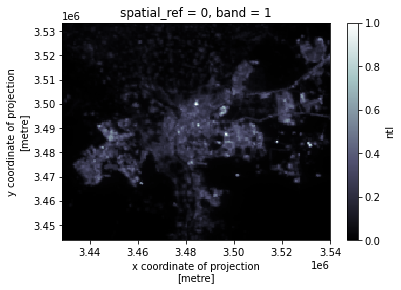

In [6]:
city = Cities['Cairo']
city.normalize_output()
city.output_normed.ntl.plot(cmap='bone')

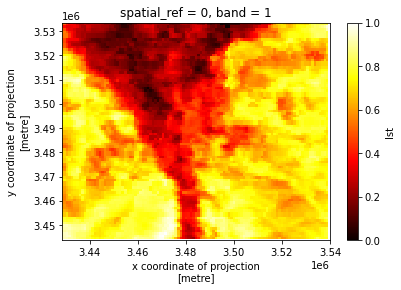

In [7]:
city.output_normed.lst[0].plot(cmap='hot')

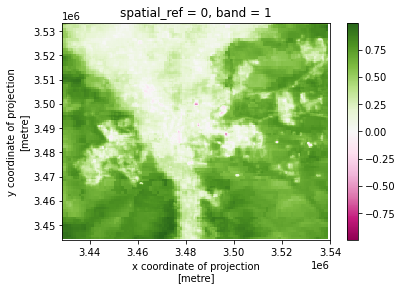

In [9]:
city.difference_map("lst", "ntl")

**We see nightlight and LST are correlated in the Urban Area, but negatively outside (desert temperatures)**

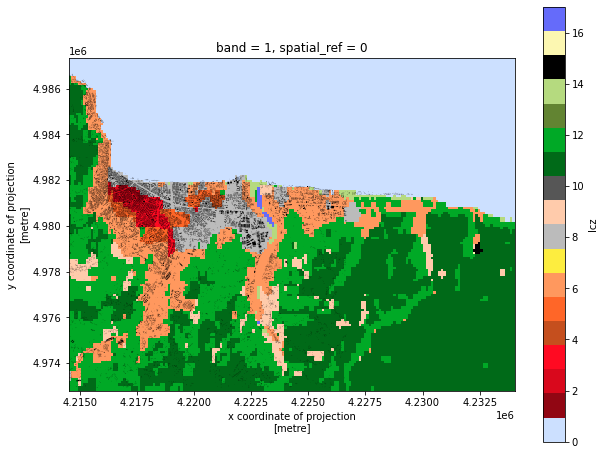

In [33]:
# lcz + MS building
ax =Cities["Ordu"].vector["MS"].geo_df.plot(zorder=999, color="k",figsize=(10,8))
Cities["Ordu"].raster["lcz"].tiff.lcz.plot(cmap=lcz_cmap, ax=ax)

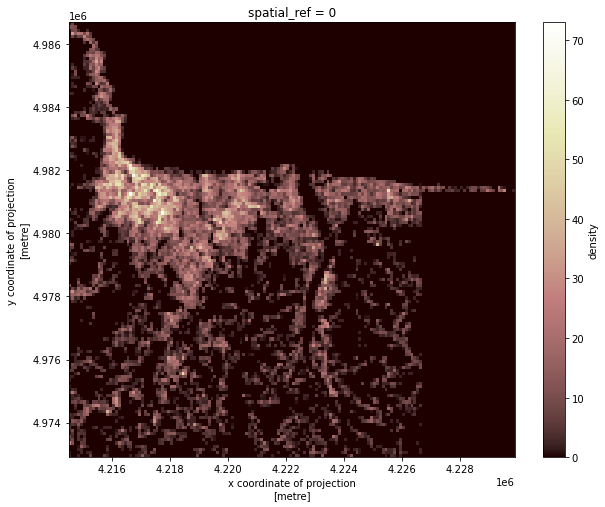

In [34]:
# building density
Cities["Ordu"].raster["MS_raster_100"].tiff.density.plot(cmap="pink",figsize=(10,8))

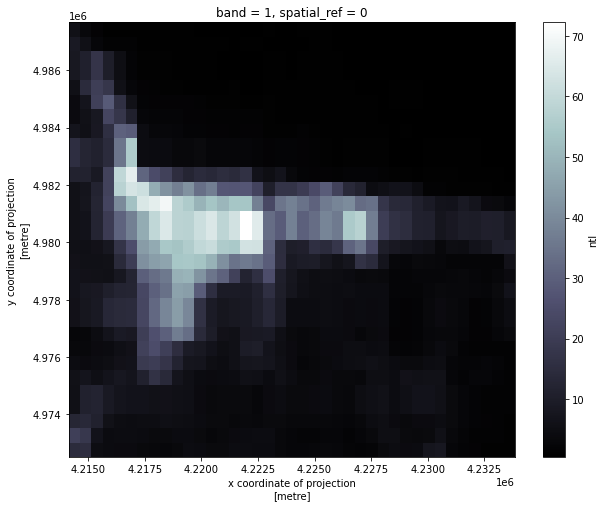

In [89]:
Cities["Ordu"].raster["ntl"].tiff.ntl.plot(cmap='bone', figsize=(10,8))

In [74]:
ds = Cities["Ordu"].raster["lst"].tiff
new_ds = ds.lst.where(ds.lst>10, drop=True)

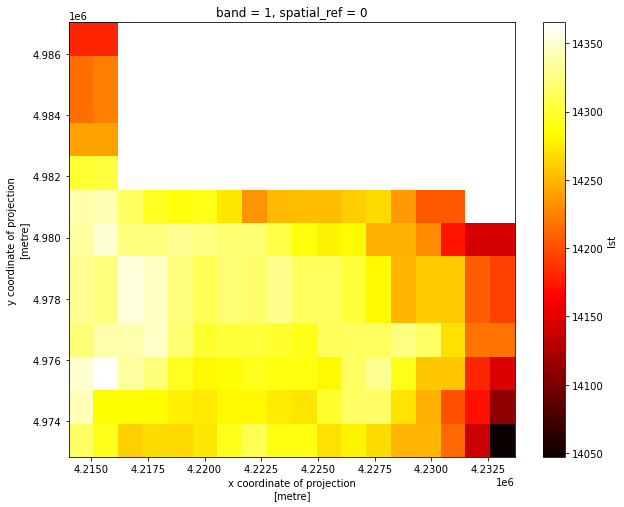

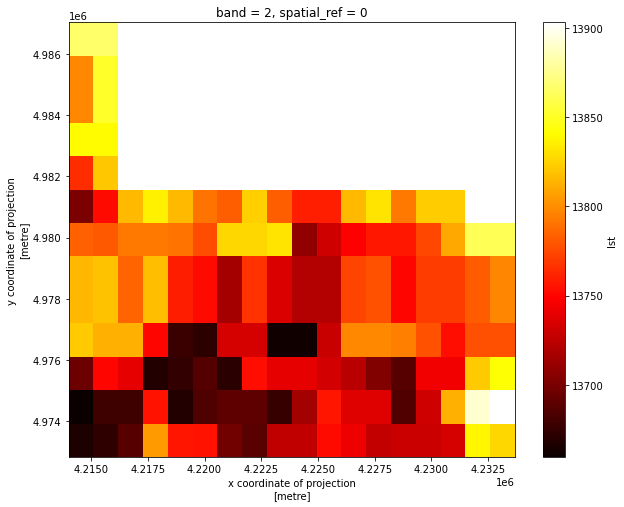

In [75]:
# Day LST
new_ds[0].plot(cmap='hot', figsize=(10,8))
# Night LST
new_ds[1].plot(cmap='hot', figsize=(10,8))